## Fig2&3 Reproduction
 
https://journals.ametsoc.org/view/journals/hydr/4/3/1525-7541_2003_004_0552_acosml_2_0_co_2.xml?tab_body=fulltext-display#i1525-7541-4-3-552-f02

https://egusphere.copernicus.org/preprints/2023/egusphere-2023-1897/egusphere-2023-1897.pdf

https://journals.ametsoc.org/view/journals/apme/58/7/jamc-d-18-0230.1.xml

questions: 
- moist_lapse function assumption is pseudo adiabat (that water falls out as soon as its created) but in findell & wood, they distinguish that CTP is not a pseudo adiabat (that water is retained), what do i want in this scenario?

- moist lapse function is non reversible and thus not adiabatic? 

- check that "soundings" df is correct

https://www.youtube.com/watch?v=XdoW_7_pD2M&ab_channel=IITRoorkeeJuly2018 

In [1]:
import pandas as pd
from func import cal_buoyancy,sounding_cal
import glob
import os
from haversine import haversine, Unit
import re
import datetime
import metpy.calc as mpcalc
from metpy.units import units
from metpy import constants
from metpy.cbook import get_test_data
from metpy.plots import add_metpy_logo, SkewT
from pyhdf import SD
from scipy.interpolate import interp1d
from scipy.optimize import bisect
import numpy as np
import pickle
import numpy as np
import math
import pint
import seaborn as sns
from pydoc import help
from pyhdf.SD import *
from sklearn.preprocessing import QuantileTransformer
import xarray as xr
import netCDF4 as nc
import re
import matplotlib.pyplot as plt
from numpy import load
from numpy import asarray
from numpy import save
import pytz
from scipy import stats
from sklearn.linear_model import LinearRegression
from collections import Counter
import pymannkendall as mk
%matplotlib inline

import warnings
warnings.filterwarnings("ignore")

In [2]:
def time_adjustment(file):
    bt = file.variables["base_time"].data
    t = file.coords["time"].data[0]
    t_off = file.variables["time_offset"].data[0]
    
    bt = pd.Timestamp(bt)
    t_off = pd.Timestamp(t_off)
    
    yr = bt.year
    month = bt.month
    day = bt.day
    
    if bt.hour == 0 and bt.minute == 0 and bt.second == 0:
        hr = t_off.hour
        minute = t_off.minute
        second = t_off.second
    else:
        hr = bt.hour
        minute = bt.minute
        second = bt.second
    
    time_final = (yr, month, day, hr, minute, second)
    time_final = datetime.datetime(*time_final)
    return(time_final)

# Set display options to show all rows and columns in dataframe
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)

In [337]:
with open('soundings_after_changes.pdkl', 'rb') as file:
    soundings = pickle.load(file)
soundings.shape

(2435, 18)

In [319]:
with open('fwi_after_changes.pdkl','rb') as file:
    fwidf = pickle.load(file)
fwidf.shape

(2834, 1)

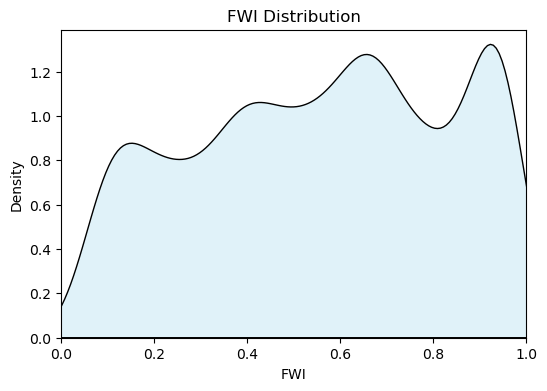

In [320]:
plt.figure(figsize=(6, 4))
sns.kdeplot(fwidf['fwi'], fill=True, color='skyblue', edgecolor='black')
plt.xlabel('FWI')
plt.xlim(0, 1)
plt.xticks([0, 0.2, 0.4, 0.6, 0.8, 1.0])
plt.title('FWI Distribution')
plt.ylabel('Density')
plt.show()

In [5]:
#read in precipitation files:
#2001-2019 warm-season

directory_path = "../../data/rong1/climate_fu/Data/DOEARM/sgp/abrfc_final"

#files either .cdf or .nc
#file name looks like: sgpabrfcprecipX1.c1.19971231.000000.custom.cdf
#file name looks like: sgpabrfcprecipX1.c1.20171231.000000.custom.nc

files = [
    os.path.join(directory_path, file)
    for file in os.listdir(directory_path)
    if file.endswith(".cdf") or file.endswith(".nc")
]

filtered_files = []
for file in files:
    file_name = os.path.basename(file)
    year_month = file_name.split('.')[2]
    if len(year_month) == 8:
        year = int(year_month[0:4])
        month = int(year_month[4:6])
        day = int(year_month[6:8])
        hours_mins_seconds = file_name.split('.')[3]
        hour = int(hours_mins_seconds[0:2])
        if 5 <= month <= 9 and year > 2000:
            filtered_files.append(file)

precipdfs = []
for ds in sorted(filtered_files):
    ds = xr.open_dataset(ds)
    precipdfs.append(ds)

In [317]:
# #read in soil moisture files:
# #2001-2019 warm-season

# directory_path = "../../data/rong1/climate_fu/Data/DOEARM/sgp/okmsoilX1"

# #files are .nc
# #look like: sgpokmsoilX1.c1.20120901.000000.nc

# files = [
#     os.path.join(directory_path, file)
#     for file in os.listdir(directory_path)
#     if file.endswith(".nc")
# ]

# filtered_files = []
# for file in files:
#     file_name = os.path.basename(file)
#     if file_name.startswith("sgpokmsoilX1"):
#         year_month = file_name.split('.')[2]
#         if len(year_month) == 8:
#             year = int(year_month[0:4])
#             month = int(year_month[4:6])
#             day = int(year_month[6:8])
#             hours_mins_seconds = file_name.split('.')[3]
#             hour = int(hours_mins_seconds[0:2])
#             if 5 <= month <= 9 and 2020 > year > 2000:
#                 filtered_files.append(file)

# soildfs = []
# for ds in sorted(filtered_files):
#     ds = xr.open_dataset(ds)
#     soildfs.append(ds)

In [8]:
# #clean soil moisture data
# def clean_fwi(df):
    
#     min_fwi = 0

#     max_fwi = 1

#     fwi = df.variables['fractional_water_index'].data
          
#     mask = ((fwi < min_fwi) | (fwi > max_fwi))

#     fwi = np.where(mask, np.nan, fwi)
#     return(fwi)

Three valid closest stations to SGP: 

-Closest Point 1 (Index 12): (36.75442886352539, -97.2545166015625)

-Closest Point 2 (Index 15): (36.412010192871094, -97.69393920898438)

-Closest Point 3 (Index 84): (36.355899810791016, -97.15306091308594)

In [312]:
# soil_station = (36.355899810791016, -97.15306091308594)

# def find_ll_index(latarray,findlat):
    
#     latindex = np.where(latarray == findlat)
    
#     lat_pos = latindex[0][0]
    
#     return lat_pos


# fwi_tuples=[]

# for df in soildfs:
    
#     date = time_adjustment(df)
    
#     latarray = df.variables['lat'].data
    
#     lonarray = df.variables['lon'].data
    
#     fwi = clean_fwi(df)
    
#     index = find_ll_index(latarray,soil_station[0])

#     #[0] means first observation of the day, [1] means 25cm depth
#     qcfwi = df.variables['qc_fractional_water_index'].data[0][1][index]
    
#     if qcfwi == 0:
        
#         fwi = fwi[0][1][index]

#         fwi_tuple = (date,fwi)

#         fwi_tuples.append(fwi_tuple)

# fwidf = pd.DataFrame(fwi_tuples,columns=['date','fwi'])
# print(fwidf.shape)

# fwidf = fwidf.dropna()
# print(fwidf.shape)

# fwidf.set_index('date', inplace=True)

(2825, 2)
(2721, 2)


In [313]:
# with open('fwi_before_changes.pdkl', 'wb') as file:
#     pickle.dump(fwidf, file)

In [13]:
#clean precipitation -- creating a list of dfs in precipdfs_clean with valid precipitation arrays 
precipdfs_clean = []

for df in precipdfs: 
    min_p = 0
    
    #equivalent to 250mm of rain per hour
    max_p = 25000

    precip = df.variables['precip'].data
          
    mask = ((precip < min_p) | (precip > max_p))

    precip_clean = np.where(mask, np.nan, precip)
    
    nans = np.sum(np.isnan(precip_clean))
    
    #filtering out all dfs with more than 0 values outside of range of valid values
    
    if nans == 0.0:
        precipdfs_clean.append(df)

In [18]:
sgp = (36.607322, -97.487643)
max_distance = 50.0  # 50 kilometers

pairs = []
index_of_pairs = []

for i in range(160):
    for j in range(336):
        lat = precipdfs_clean[0].variables["lat"].data[i, j]
        
        lon = precipdfs_clean[0].variables["lon"].data[i, j]
        
        lat_lon_pair = (lat,lon)
        
        distance = haversine(sgp, lat_lon_pair, unit='km')
        
        if distance <= max_distance:
            
            pair = (lat, lon)
            
            index = (i, j)
            
            pairs.append(pair)
            
            index_of_pairs.append(index)

print(len(pairs))

472


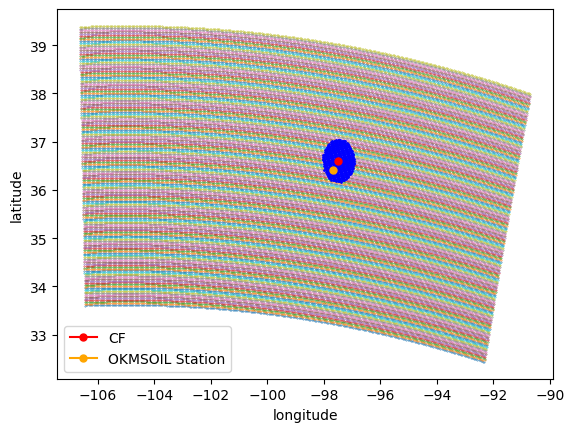

In [15]:
#plot of lat/lon boundaries and sgp facility point

for i in range(159):
    lat = precipdfs_clean[0].variables["lat"].data[i]
    lon = precipdfs_clean[0].variables["lon"].data[i]
    plt.scatter(lon,lat,s=0.1)

#surrounding half degree 
for i,j in enumerate(pairs):
    plt.plot(j[1],j[0],marker='o',color='blue',markersize=1)

#sgp facility
sgp = (36.607322,-97.487643)
soil = soil_station

plt.plot(sgp[1], sgp[0], marker='o', color='red', markersize=5,label='CF')
plt.plot(soil[1],soil[0],marker='o', color='orange', markersize=5,label='OKMSOIL Station')
plt.xlabel('longitude')
plt.ylabel('latitude')
plt.legend()

Something could be wrong with my daily precipitation calculation. I am taking an average of hourly precipitation across a circular radius surrounding the SGP CF facility (see figure above).  

In [16]:
p_per_hr = []

for df in precipdfs_clean:
    
    time = time_adjustment(df)
    
    precip_totals = np.zeros(df.variables['precip'].shape[0])
    
    for index in index_of_pairs:
        
        hrs = df.variables['precip'].shape[0]
        
        for hr in range(hrs): 
            
            p = df.variables['precip'].data[hr,index[0],index[1]]
            
            precip_totals[hr] += p
    
    avg_precip = precip_totals / len(index_of_pairs)

    p_per_hr.append((time, avg_precip))

In [262]:
#converting p_per_hr to a df

pdf = pd.DataFrame(p_per_hr,columns=['date','avgp'])

tuples = []

for i in range(pdf.shape[0]):
    
    date = pdf['date'][i]
    
    precipitation_array = pdf['avgp'][i]
    
    if len(precipitation_array) == 24:
        
        #corresponds to hours 6-13
        #used before: 12:20
        precip_morning = sum(precipitation_array[13:21])
        
        #used before: 20:24
        precip_afternoon1 = sum(precipitation_array[21:24])
        
        #used before: 0:3
        precip_afternoon2 = sum(precipitation_array[0:4])
        
        #corresponds to hours 14-20
        precip_afternoon = precip_afternoon1+precip_afternoon2
    
        #corresponds to hours 21-24
        #used before: 3:7
        precip_evening = sum(precipitation_array[4:8])

        tup = (date,precip_morning,precip_afternoon,precip_evening)
        
        tuples.append(tup)

pdf_time_ranges = pd.DataFrame(tuples,columns=['date','morning','afternoon','evening'])

#APE conditions

pdf_time_ranges['APE'] = (pdf_time_ranges['afternoon'] > pdf_time_ranges['evening']) & (pdf_time_ranges['afternoon'] > 2 * pdf_time_ranges['morning'])

pdf = pdf_time_ranges[['date','APE','afternoon']]

pdf.set_index('date', inplace=True)

np.sum(pdf['APE'])


620

In [228]:
with open('pdffig6.pdkl', 'wb') as file:
    pickle.dump(pdf_time_ranges, file)

In [92]:
# #old method
# #converting p_per_hr to a df

# pdf = pd.DataFrame(p_per_hr,columns=['date','avgp'])

# pdf_time_ranges = pd.DataFrame(columns=['date', 'precip_6_13', 'precip_14_20', 'precip_21_24'])

# # hours shifted like this because original time in GMT:
# # 18,19,20,21,22,23,24,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17

# for index, row in pdf.iterrows():
    
#     date = row['date']
    
#     precipitation_array = row['avgp']
    
#     precip_morning = sum(precipitation_array[11:18])
    
#     precip_afternoon = np.sum(np.concatenate((precipitation_array[19:23], precipitation_array[0:1])))
    
#     precip_evening = sum(precipitation_array[2:5])


# #     precip_morning = sum(precipitation_array[12:19])
    
# #     precip_afternoon = np.sum(np.concatenate((precipitation_array[20:23], precipitation_array[0:2])))
    
# #     precip_evening = sum(precipitation_array[3:6])

#     pdf_time_ranges = pdf_time_ranges.append({'date': date, 'precip_morning': precip_morning, 'precip_afternoon': precip_afternoon, 'precip_evening': precip_evening}, ignore_index=True)

# #APE conditions

# pdf_time_ranges['APE'] = (pdf_time_ranges['precip_afternoon'] > pdf_time_ranges['precip_evening']) & (pdf_time_ranges['precip_afternoon'] > 2 * pdf_time_ranges['precip_morning'])

# pdf = pdf_time_ranges[['date','APE']]

# pdf.set_index('date', inplace=True)

# np.sum(pdf['APE'])

In [231]:
# def calculate_hi_low(row):
    
#     pres = row['interp_pres']

#     _50_hpa = pres[0] - 50
#     _50_hpa_index = np.argmax(pres <= _50_hpa)

#     _150_hpa = pres[0] - 150
#     _150_hpa_index = np.argmax(pres <= _150_hpa)

#     tdry_50 = row['interp_temp'][_50_hpa_index]
#     dp_50 = row['interp_dp'][_50_hpa_index]

#     tdry_150 = row['interp_temp'][_150_hpa_index]
#     dp_150 = row['interp_dp'][_150_hpa_index]

#     return (tdry_150 - dp_150) + (tdry_50 - dp_50)

# soundings['hi_low'] = soundings.apply(calculate_hi_low, axis=1)
# soundings.shape

(2435, 17)

In [340]:
# plt.figure(figsize=(10, 6))
# plt.hist(soundings['hi_low'], bins=30, edgecolor='black')
# plt.xlabel('hi_low')
# plt.title('Hi_low Distribution')
# plt.ylabel('Frequency')
# plt.show()

Something could be be wrong with my ctp calculation below. The process is as follows: I am creating a moist lapse rate starting at 100hpa above ground level and integrating the difference between the moist lapse rate and the environmental temperature between 100hpa-300hpa above ground level. 

In [330]:
# #fergeson & wood approach

# def calculate_ctp_fw(row):
    
#     pres = row['interp_pres'] * units.hPa
    
#     is_decreasing = np.all(np.diff(pres) < 0)
    
#     if is_decreasing == True:
        
#         p100 = pres[0]-100*units.hPa
#         print(p100)
        
#         p150 = pres[0]-150*units.hPa
        
#         p100index = np.argwhere(pres <= p100).min()

#         p150index = np.argwhere(pres <= p150).min()

#         tdry = row['interp_temp']
        
#         t100 = tdry[p100index]

#         t150 = tdry[p150index]
        
#         es100 = mpcalc.saturation_vapor_pressure(t100*units.degC).to(units.hectopascal)
        
#         es150 = mpcalc.saturation_vapor_pressure(t150*units.degC).to(units.hectopascal)
        
#         qs100 = (0.622*es100)/p100
        
#         qs150 = (0.622*es150)/p150
        
#         dry_adiabat = 9.8 

#         lv = 2500000

#         cp = 1004

#         dqs = qs100-qs150

#         dt = t100-t150

#         malr = -dry_adiabat*(1 + (lv/cp)*(dqs/dt))

#         return malr
    

# test = soundings.apply(calculate_ctp_fw, axis=1)



In [341]:
# def calculate_ctp(row):
    
#     pres = row['interp_pres'] * units.hPa
    
#     is_decreasing = np.all(np.diff(pres) < 0)
    
#     if is_decreasing == True:

#         pmax = pres[0]-100*units.hPa

#         pmin = pres[0]-300*units.hPa

#         index_100hPa_agl = np.argwhere(pres <= pmax).min()

#         index_300hPa_agl = np.argwhere(pres <= pmin).min()

#         pressure_at_100hPa_agl = pres[index_100hPa_agl]
        
#         pressure_at_300hPa_agl = pres[index_300hPa_agl]

#         p_range = (pres.magnitude <= pressure_at_100hPa_agl.magnitude) & (pres.magnitude >= pressure_at_300hPa_agl.magnitude)

#         tdry = row['interp_temp'] * units.degC

#         temp_at_100hPa_agl = tdry[index_100hPa_agl]

# #         row_index = soundings.index.get_loc(row.name)

# #         print(f"Processing row with index: {row_index}")

#         moist_lapse_profile = mpcalc.moist_lapse(pres, temp_at_100hPa_agl, reference_pressure=pressure_at_100hPa_agl)

#         temp_diff = moist_lapse_profile - tdry

#         y = temp_diff[p_range]
#         y = y.magnitude

#         x = pres[p_range]
#         x = x.magnitude
        
#         ml = moist_lapse_profile[p_range]
#         ml = ml.magnitude
                
#         tdry = tdry[p_range]
#         tdry = tdry.magnitude

#         ctp = (constants.Rd*(np.trapz(y, np.log(x)) * units.degK)).to(units('J/kg'))
        
# #         plt.figure(figsize=(5, 3))
# #         plt.plot(y,x,label='diff')
        
# #         print(-np.trapz(y,x))
# #         plt.scatter(temp_at_100hPa_agl, pressure_at_100hPa_agl, color='red', label='start moist profile')

# #         plt.plot(ml,x,label='moist')

# #         plt.plot(tdry,x,label='temp_profile')

# #         plt.gca().invert_yaxis()
# #         plt.legend()
# #         plt.grid()
# #         plt.show()
    
#     else:
#         print('non decreasing pressure')
#         ctp = np.nan
    
#     return -ctp
    

# soundings['ctp'] = soundings.apply(calculate_ctp, axis=1)

# plt.figure(figsize=(6, 4))
# plt.hist(soundings['ctp'], bins=30, edgecolor='black')
# plt.xlabel('ctp')
# plt.title('CTP Distribution')
# plt.ylabel('Frequency')
# plt.show()

In [336]:
# ctp_before_changes = pd.DataFrame(soundings['ctp'])
# ctp_before_changes['ctp'] = ctp_before_changes['ctp'].apply(lambda x: x.magnitude)


# with open('ctp_before_changes.pdkl', 'wb') as file:
#     pickle.dump(ctp_before_changes, file)

- ml temp profile should conserve equivalent potential temperature
- if it doesn't conserve, then use newton ralphson with equivalent potential temperature (y, x = tdry)

In [342]:
# #visualization of moist profile calculation

# from metpy.calc import moist_lapse

# from metpy.units import units

# index = 10

# pres = soundings['interp_pres'][index]

# pres = pres * units.hPa

# pmax = pres[0]-100*units.hPa

# pmin = pres[0]-300*units.hPa

# index_100hPa_agl = np.argwhere(pres <= pmax).min()

# index_300hPa_agl = np.argwhere(pres <= pmin).min()

# pressure_at_100hPa_agl = pres[index_100hPa_agl]
# pressure_at_300hPa_agl = pres[index_300hPa_agl]

# p_range = (pres.magnitude <= pressure_at_100hPa_agl.magnitude) & (pres.magnitude >= pressure_at_300hPa_agl.magnitude)
              
# tdry = soundings['interp_temp'][index] * units.degC

# temp_at_100hPa_agl = tdry[index_100hPa_agl]

# dp = soundings['interp_dp'][index] * units.degC

# ml = moist_lapse(pres, temp_at_100hPa_agl, reference_pressure=pressure_at_100hPa_agl).to('degC')

# pp = mpcalc.parcel_profile(pres, tdry[0], dp[0]).to('degC')

# tdry = tdry[p_range]
# tdry = tdry.magnitude

# pres = pres[p_range]
# pres = pres.magnitude

# ml = ml[p_range]
# ml = ml.magnitude

# pp = pp[p_range]
# pp = pp.magnitude

# dp = dp[p_range]

# diff = ml - tdry

# # plt.plot(diff,pres,label='diff')

# plt.scatter(temp_at_100hPa_agl, pressure_at_100hPa_agl, color='red', label='start moist profile')

# plt.plot(pp,pres,label='parcel_profile',color='purple')

# plt.plot(ml,pres,label='moist')

# plt.plot(tdry,pres,label='temp_profile')

# plt.gca().invert_yaxis()
# plt.legend()
# plt.grid()

# ctp = (constants.Rd*(np.trapz(diff, np.log(pres)) * units.degK)).to(units('J/kg'))
# print(-np.trapz(diff,pres))

In [344]:
soundings.columns

Index(['pres', 'alt', 'dp', 'rh', 'tdry', 'interp_alt', 'interp_temp',
       'interp_dp', 'interp_pres', 'interp_rh', 'q_obs', 'q_fit', 'br', 'blc',
       'blt', 'tercile', 'hi_low', 'ctp'],
      dtype='object')

In [345]:
soundings.index = soundings.index.date

resultdf = pd.merge(soundings, pd.merge(pdf, fwidf, left_index=True, right_index=True), left_index=True, right_index=True)

# resultdf = resultdf.dropna(subset=['ctp'])

resultdf = resultdf.rename(columns={'hi_low': 'hilow'})

resultdf.shape

(2299, 21)


Something could be wrong with my normal quantile transform below. I am calculating CTP and HI_LOW anamolies by transforming the calculations from every day (between the years 2001-2019) into a noromal distribution. 

### Wakefield z-scores for CTP/HI_low

a normal quantile transform (Wilks 2011) was used to obtain z scores.

Each daily distribution for each station was transformed into a cumulative probability density function. 

From the derived CDF, each daily value was assigned a cumulative probability, and this probability was used to compute the z score.

https://proclusacademy.com/blog/practical/normal-distribution-python-scipy/ 

In [346]:
# # old method

# resultdf['month'] = resultdf.index.month
# resultdf['day'] = resultdf.index.day
# resultdf['ctp'] = resultdf['ctp'].apply(lambda x: x.magnitude)

# resultdf['daily_ctp_mean'] = resultdf.groupby(['month', 'day'])['ctp'].transform('mean')
# resultdf['daily_ctp_std'] = resultdf.groupby(['month', 'day'])['ctp'].transform('std')

# resultdf['ctpz_m1'] = (resultdf['ctp'] - resultdf['daily_ctp_mean'])/resultdf['daily_ctp_std']

# resultdf['daily_hi_low_mean'] = resultdf.groupby(['month', 'day'])['hilow'].transform('mean')
# resultdf['daily_hi_low_std'] = resultdf.groupby(['month','day'])['hilow'].transform('std')

# resultdf['hilowz_m1'] = (resultdf['hilow'] - resultdf['daily_hi_low_mean'])/resultdf['daily_hi_low_std']


In [348]:
resultdf['month'] = resultdf.index.month

resultdf['day'] = resultdf.index.day

# resultdf['ctp'] = resultdf['ctp'].apply(lambda x: x.magnitude)

ctpdf = resultdf.groupby(['month', 'day'])['ctp'].agg(list).reset_index()

ctpdf['ctpz']=""

for i in range(ctpdf.shape[0]):
    
    x = np.array(ctpdf['ctp'][i])

    x = x.reshape(-1, 1)

    qt = QuantileTransformer(output_distribution='normal')

    xqt = qt.fit_transform(x)
    
    ctpdf['ctpz'][i] = xqt
    
#output of xqt puts every value in a list, this removes the inner lists
ctpdf['ctpz'] = ctpdf['ctpz'].apply(lambda x: [item for sublist in x for item in sublist])  

ctp_raw = ctpdf.explode('ctp').drop('ctpz',axis=1)

ctp_z = ctpdf.explode('ctpz').drop('ctp',axis=1)

ctpz = ctp_z['ctpz']

ctpdf = pd.concat([ctp_raw, ctpz], axis=1)

resultdf = pd.merge(resultdf, ctpdf[['month', 'day', 'ctp', 'ctpz']], on=['month', 'day', 'ctp'], how='left')

In [349]:
hilowdf = resultdf.groupby(['month', 'day'])['hilow'].agg(list).reset_index()

hilowdf = hilowdf.rename(columns={'hilow': 'hilow'})

hilowdf['hilowz']=""

for i in range(hilowdf.shape[0]):
    
    x = np.array(hilowdf['hilow'][i])

    x = x.reshape(-1, 1)

    qt = QuantileTransformer(output_distribution='normal')

    xqt = qt.fit_transform(x)
    
    hilowdf['hilowz'][i] = xqt
    
hilowdf['hilowz'] = hilowdf['hilowz'].apply(lambda x: [item for sublist in x for item in sublist])  

hilow_raw = hilowdf.explode('hilow').drop('hilowz',axis=1)

hilow_z = hilowdf.explode('hilowz').drop('hilow',axis=1)

hilowz = hilow_z['hilowz']

hilowdf = pd.concat([hilow_raw, hilowz], axis=1)

resultdf = pd.merge(resultdf, hilowdf[['month', 'day', 'hilow', 'hilowz']], on=['month', 'day', 'hilow'], how='left')

In [350]:
#dry coupling: positive CTP anomaly AND FWI < 0.4, wet coupling: negative HI_low anomaly AND FWI > 0.7

resultdf['dry_coupling'] = (resultdf['ctpz'] > 0) & (resultdf['fwi'] < 0.4)

resultdf['wet_coupling'] = (resultdf['hilowz'] < 0) & (resultdf['fwi'] > 0.7)

In [351]:
drydf = resultdf[resultdf['dry_coupling'] == True]

drydf = drydf[['interp_temp','q_obs','interp_rh','APE']]

wetdf = resultdf[resultdf['wet_coupling'] == True]

wetdf = wetdf[['interp_temp','q_obs','interp_rh','APE','interp_alt']]

print("dry:",drydf.shape[0]/resultdf.shape[0],"wet:",wetdf.shape[0]/resultdf.shape[0])

#should be about equal and around 17%

dry: 0.17007394519356242 wet: 0.17485863418877773


In [255]:
# with open('fig6df.pdkl', 'wb') as file:
#     pickle.dump(resultdf, file)

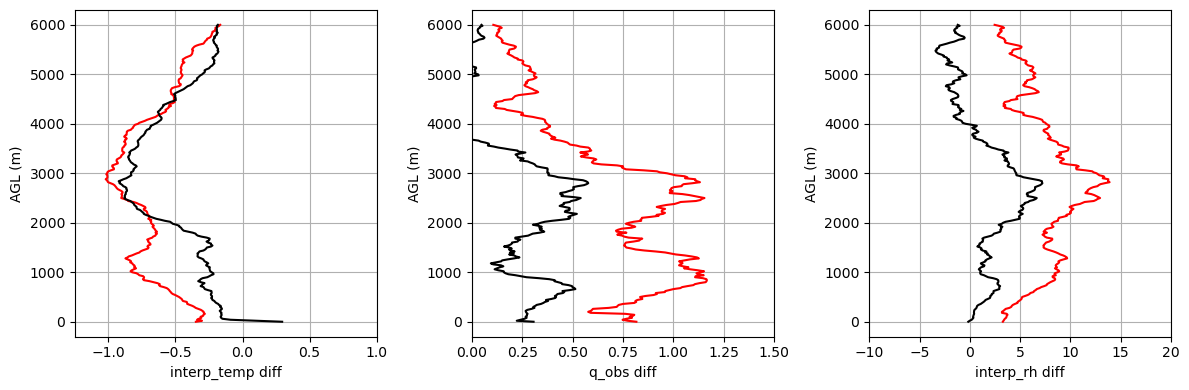

In [353]:
def composite_profile(arrays):
    return np.nanmean(arrays.tolist(), axis=0)

fig2vars = ['interp_temp', 'q_obs', 'interp_rh']

y = resultdf['interp_alt'][0]
y = y[0:301]

num_cols = len(fig2vars)

fig, axs = plt.subplots(1, num_cols, figsize=(num_cols * 4, 4))

for i, var in enumerate(fig2vars):
    
    drytrue = composite_profile(drydf[drydf['APE'] == True][var])

    
    dryfalse = composite_profile(drydf[drydf['APE'] == False][var])
    

    wettrue = composite_profile(wetdf[wetdf['APE'] == True][var])

    
    wetfalse = composite_profile(wetdf[wetdf['APE'] == False][var])

    xdry = drytrue - dryfalse
    
    xdry = xdry[0:301]
    
    xwet = wettrue - wetfalse
    
    xwet = xwet[0:301]
    
    if var == 'interp_temp':
        axs[i].plot(xdry, y, color='red', label='Dry Coupling')
        axs[i].plot(xwet, y, 'black', label='Wet Coupling')
        axs[i].set_xlabel(f'{var} diff')
        axs[i].set_ylabel('AGL (m)')
        axs[i].grid()
        axs[i].set_xlim(-1.25, 1.0)
        ticks = np.arange(-1, 1.5, 0.5)
        axs[i].set_xticks(ticks)
        
    elif var == 'q_obs':
        axs[i].plot(xdry, y, color='red', label='Dry Coupling')
        axs[i].plot(xwet, y, 'black', label='Wet Coupling')
        axs[i].set_xlabel(f'{var} diff')
        axs[i].set_ylabel('AGL (m)')
        axs[i].grid()
        axs[i].set_xlim(0, 1.5)
        ticks = np.arange(0, 1.75, 0.25)
        axs[i].set_xticks(ticks)
        
    else:
        axs[i].plot(xdry, y, color='red', label='Dry Coupling')
        axs[i].plot(xwet, y, 'black', label='Wet Coupling')
        axs[i].set_xlabel(f'{var} diff')
        axs[i].set_ylabel('AGL (m)')
        axs[i].grid()
        axs[i].set_xlim(-10, 20)
        ticks = np.arange(-10, 25, 5)
        axs[i].set_xticks(ticks)

plt.tight_layout()

plt.show()


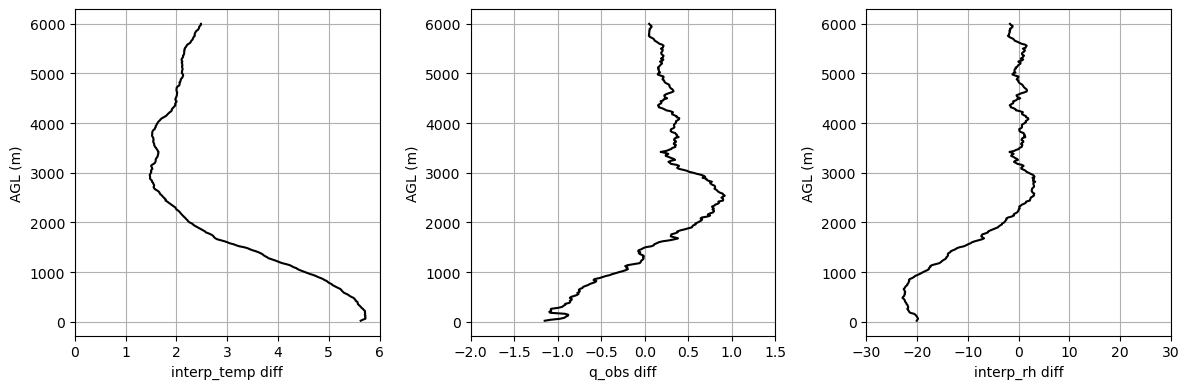

In [354]:
#figure 3 construction

apesdf = resultdf[resultdf['APE'] == True]

fig3vars = ['interp_temp', 'q_obs', 'interp_rh']

y = resultdf['interp_alt'][0]
y = y[1:301]

num_cols = len(fig3vars)

fig, axs = plt.subplots(1, num_cols, figsize=(num_cols * 4, 4))

for i, var in enumerate(fig3vars):
    
    dry = composite_profile(apesdf[apesdf['dry_coupling'] == True][var])

    wet = composite_profile(apesdf[apesdf['wet_coupling'] == True][var])        
    
    diff = dry - wet
    
    #truncate to only 6000 km AGL
    diff = diff[1:301]
    
    if var == 'interp_temp':
        
        axs[i].set_xlim(0, 6)
        ticks = np.arange(0, 7, 1)
        axs[i].set_xticks(ticks)
   
    elif var == 'q_obs':
        
        axs[i].set_xlim(-2, 1)
        ticks = np.arange(-2, 2, 0.5)
        axs[i].set_xticks(ticks)
    
    else: 
        
        axs[i].set_xlim(-30, 30)
        ticks = np.arange(-30, 40, 10)
        axs[i].set_xticks(ticks)
    

    axs[i].plot(diff, y, color='black')
    axs[i].set_xlabel(f'{var} diff')
    axs[i].set_ylabel('AGL (m)')
    axs[i].grid()

plt.tight_layout()

plt.show()

- In general, T is higher for APEs under dry-coupling than under wet-coupling regime (Figure 3a) especially in the PBL (below 2 km). This can be attributed to stronger sensible heat flux and temperature mixing over a dry surface. 

- Notably, there is a significant difference in LT specific humidity between dry- and wet-coupling regimes (Figure 3b), with q associated with APEs being slightly lower below 1 km AGL under dry-coupling than under wetcoupling regime, but higher above 1 km, especially between 2 km and 3 km AGL. This suggests that APEs require entrainment of higher LT moisture under dry-coupling than under wet-coupling regimes. 

- Both Figures 2b and 3b suggest that higher LT specific humidity is needed for APEs under the dry-coupling than under the wet-coupling regimes. Moreover, RH associated with dry-coupling regimes is less than that of wet-coupling regimes in the PBL (Figure 3c), as expected from a drier PBL over a dry surface. However, such an RH difference becomes smaller and eventually disappears in the LT (2-4 km). This is because the lower RH in the dry-coupling regimes is mainly due to warmer T below 2 km AGL (Figure 3b), whereas above 2 km AGL, the higher q and slightly warmer T in the drycoupling regimes balance each other out and lead to a similar RH as in the wet-coupling regimes. 

In [355]:
#apes comparison to gaoyuns
#conclusion is that APE proportion not too far off
#but dry/wet categorization not as even as they should be 


apesdf = resultdf[resultdf['APE'] == True]

print("total ape count: ", "mine:", (apesdf.shape[0]/resultdf.shape[0])*100, "gloria's:", (368/2172)*100)
print("")

apesdry = apesdf[apesdf['dry_coupling'] == True]

apeswet = apesdf[apesdf['wet_coupling'] == True]

print("total dry coupling cases: ", "mine:", (drydf.shape[0]/resultdf.shape[0])*100, "gloria's:", (388/2172)*100)
print("")
print("total wet coupling cases: ", "mine:", (wetdf.shape[0]/resultdf.shape[0])*100, "gloria's:", (389/2172)*100)
print("")
print("dry coupling apes count: ", "mine:", (apesdry.shape[0]/drydf.shape[0])*100, "gloria's:", (94/388)*100)
print("")
print("wet coupling apes count: ", "mine:", (apeswet.shape[0]/wetdf.shape[0])*100, "gloria's:", (79/389)*100)
print("")

total ape count:  mine: 22.31404958677686 gloria's: 16.94290976058932

total dry coupling cases:  mine: 17.007394519356243 gloria's: 17.863720073664823

total wet coupling cases:  mine: 17.485863418877774 gloria's: 17.909760589318598

dry coupling apes count:  mine: 28.13299232736573 gloria's: 24.22680412371134

wet coupling apes count:  mine: 28.35820895522388 gloria's: 20.308483290488432



In [ ]:
#why are non-apes less accurate? look into non-apes 

In [357]:
test = np.array([1,12,3,5,2,2,4])
test[0:3]

array([ 1, 12,  3])